**Instructions**

1. We will start with removing outliers. So far, we have discussed different methods to remove outliers. Use the one you feel more comfortable with, define a function for that. Use the function to remove the outliers and apply it to the dataframe.
2. Create a copy of the dataframe for the data wrangling.
3. Normalize the continuous variables. You can use any one method you want.
4. Encode the categorical variables
5. The time variable can be useful. Try to transform its data into a useful one. Hint: Day week and month as integers might be useful.
6. Since the model will only accept numerical data, check and make sure that every column is numerical, if some are not, change it using encoding.

*Hint for Categorical Variables*
You should deal with the categorical variables as shown below (for ordinal encoding, dummy code has been provided as well):

- One hot to state
- Ordinal to coverage
- Ordinal to employmentstatus
- Ordinal to location code
- One hot to marital status
- One hot to policy type
- One hot to policy
- One hot to renew offer
- One hot to sales channel
- One hot vehicle class
- Ordinal vehicle size

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
customer_data=pd.read_csv('customer_data.csv')
customer_data.sample(5)

,customer,state,response,coverage,education,employment_status,location_code,policy,renew_offer_type,sales_channel,vehicle_class,effective_to_date,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount
8982,ZG54759,California,No,Basic,Bachelor or College,Employed,Urban,Corporate,Offer 1-2,Direct,Normal Car,2011-01-17,2837.007353,41408,73,4,89,1,1,268.710908
2627,QW40898,Arizona,Yes,Basic,Bachelor or College,Other status,Suburban,Personal,Offer 1-2,Indirect,Normal Car,2011-02-02,2722.210707,17576,71,29,70,0,1,398.502948
7751,EL44544,Oregon,No,Basic,High School or Below,Employed,Suburban,Corporate,Offer 1-2,Direct,Normal Car,2011-02-07,13009.241250,57591,66,5,74,0,2,316.800000
4458,SL71970,Oregon,No,Basic,High School or Below,Unemployed,Suburban,Special,Offer 1-2,Direct,Normal Car,2011-02-28,2336.177331,0,67,21,28,0,1,458.661381
3041,JO98946,Oregon,No,Basic,Bachelor or College,Employed,Suburban,Personal,Offer 1-2,Direct,Normal Car,2011-02-10,2655.996158,31796,68,27,16,0,1,377.442796


### 1. We will start with removing outliers. Define a function for that. 

In [3]:
nums = customer_data.select_dtypes(include=[np.number])
nums.columns

Index(['customer_lifetime_value', 'income', 'monthly_premium_auto',
       'months_since_last_claim', 'months_since_policy_inception',
       'number_of_open_complaints', 'number_of_policies',
       'total_claim_amount'],
      dtype='object')

In [4]:
nums.customer_lifetime_value.describe()

count     9134.000000
mean      8004.940475
std       6870.967608
min       1898.007675
25%       3994.251794
50%       5780.182197
75%       8962.167041
max      83325.381190
Name: customer_lifetime_value, dtype: float64

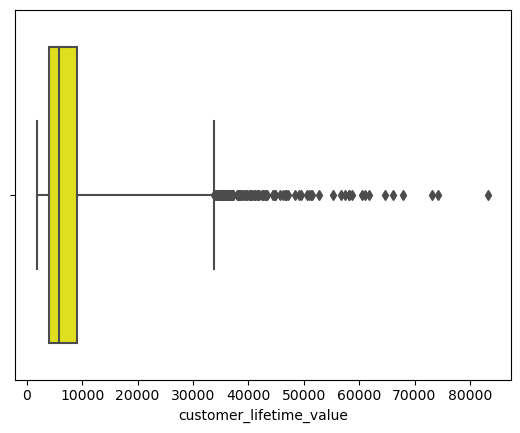

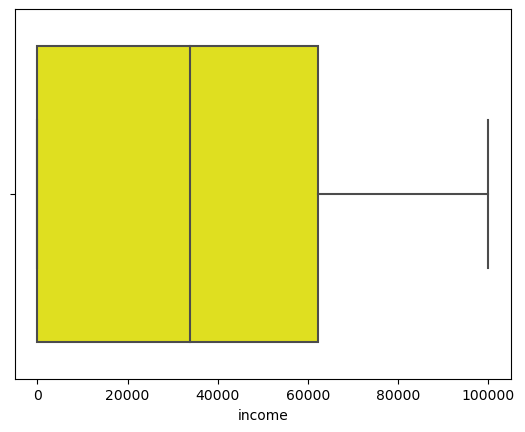

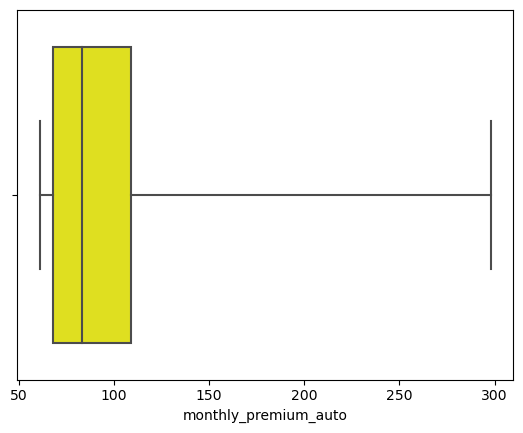

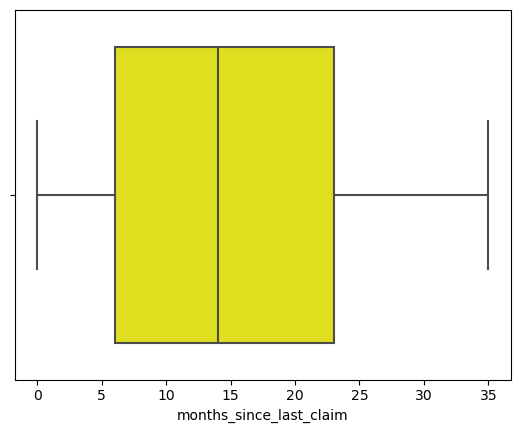

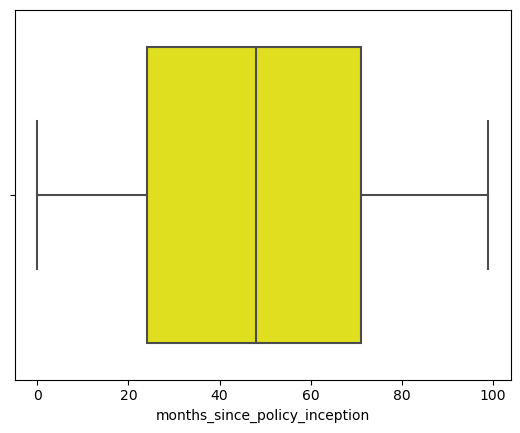

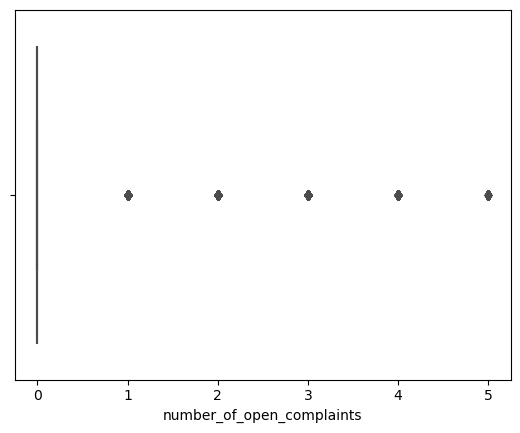

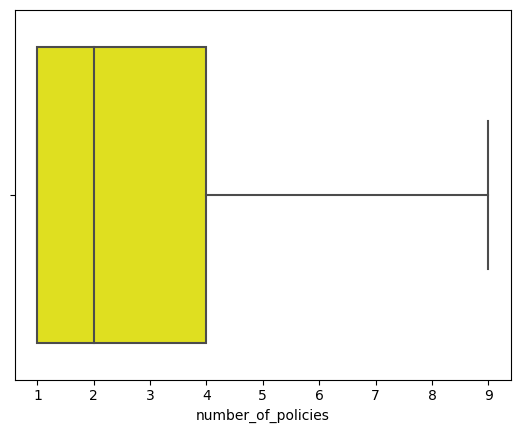

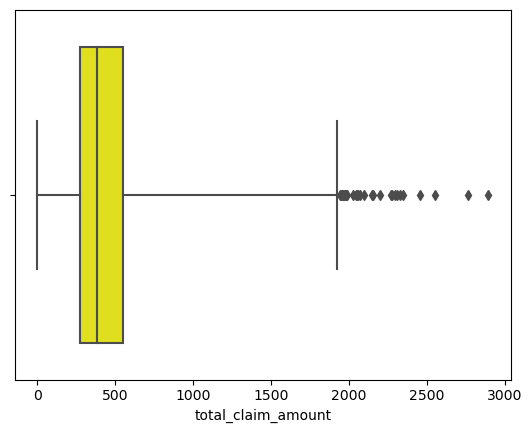

In [5]:
# First I want to check if there are many outliers (as I did already in the lab-cleaning-numerical-data).
for col in nums:
    sns.boxplot(x=nums[col], whis=5, color='yellow')
    plt.show()

I will remove most of the outliers from the columns 'customer_lifetime_value'. The column 'number_of_open_complaints' shows outliers in the boxplot, but these cannot be considered true outliers since the column only has 6 distinct values (see below).

In [6]:
nums.number_of_open_complaints.nunique()

6

I decide not to remove outliers from the target after I researched and thought a bit more on it. 
Removing outliers from the target variable can introduce bias and affect the accuracy of the model. Since I want to predict it, it's important to preserve the integrity of the data as much as possible. Outliers in the total claim amount may represent extreme or unusual cases that are important to capture in the model, as they may have a significant impact on the predicted outcome.

In [7]:
def remove_outliers(data, col_name, factor):
    lower = np.percentile(data[col_name], 25)
    upper = np.percentile(data[col_name], 75)
    iqr = upper - lower
    upper_limit = upper + factor * iqr
    lower_limit = lower - factor * iqr
    cleaned_data = data[(data[col_name] > lower_limit) & (data[col_name] < upper_limit)]
    
    return cleaned_data

In [8]:
nums_outliers_removed = remove_outliers(nums, 'customer_lifetime_value', factor=4)

I can play with the factor to increase or decrease the threshold to decide how much I wnat to reduce or not reduce the dataset.

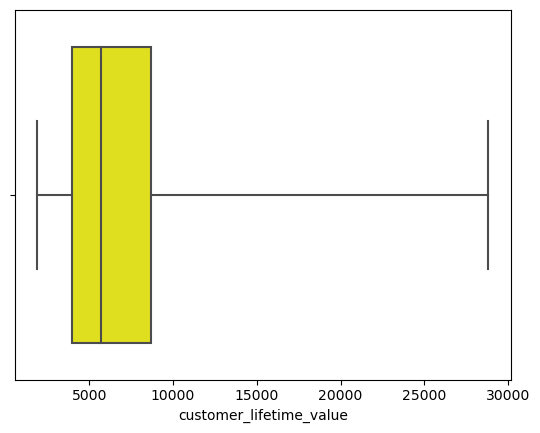

In [9]:
sns.boxplot(x='customer_lifetime_value', data=nums_outliers_removed, whis=5, color='yellow')
plt.show()

In [10]:
customer_data['customer_lifetime_value'] = nums_outliers_removed['customer_lifetime_value']
customer_data.customer_lifetime_value.describe()

count     8928.000000
mean      7313.662970
std       5014.583089
min       1898.007675
25%       3938.451162
50%       5678.048439
75%       8709.452732
max      28824.061930
Name: customer_lifetime_value, dtype: float64

I have to check for NaNs now because I removed quite a number of values from the customer lifetime value. I will not be able to normalize or scale the data with NaNs in the dataset.

In [11]:
customer_data.isna().sum()

customer                           0
state                              0
response                           0
coverage                           0
education                          0
employment_status                  0
location_code                      0
policy                             0
renew_offer_type                   0
sales_channel                      0
vehicle_class                      0
effective_to_date                  0
customer_lifetime_value          206
income                             0
monthly_premium_auto               0
months_since_last_claim            0
months_since_policy_inception      0
number_of_open_complaints          0
number_of_policies                 0
total_claim_amount                 0
dtype: int64

In [12]:
customer_data = customer_data.dropna(subset=['customer_lifetime_value'])

### 2. Create a copy of the dataframe for the data wrangling.

In [13]:
customer_copy = customer_data.copy()
customer_copy.head()

,customer,state,response,coverage,education,employment_status,location_code,policy,renew_offer_type,sales_channel,vehicle_class,effective_to_date,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount
0,BU79786,Washington,No,Basic,Bachelor or College,Employed,Suburban,Corporate,Offer 1-2,Direct,Normal Car,2011-02-24,2763.519279,56274,69,32,5,0,1,384.811147
1,QZ44356,Arizona,No,Extended,Bachelor or College,Unemployed,Suburban,Personal,Offer 3-4,Direct,Normal Car,2011-01-31,6979.535903,0,94,13,42,0,8,1131.464935
2,AI49188,Nevada,No,Premium,Bachelor or College,Employed,Suburban,Personal,Offer 1-2,Direct,Normal Car,2011-02-19,12887.431650,48767,108,18,38,0,2,566.472247
3,WW63253,California,No,Basic,Bachelor or College,Unemployed,Suburban,Corporate,Offer 1-2,Indirect,Medium-Class Car,2011-01-20,7645.861827,0,106,18,65,0,7,529.881344
4,HB64268,Washington,No,Basic,Bachelor or College,Employed,Rural,Personal,Offer 1-2,Direct,Normal Car,2011-02-03,2813.692575,43836,73,12,44,0,1,138.130879


### 3. Normalize the continuous variables. You can use any one method you want.

In [14]:
nums = customer_copy.select_dtypes(include=[np.number])

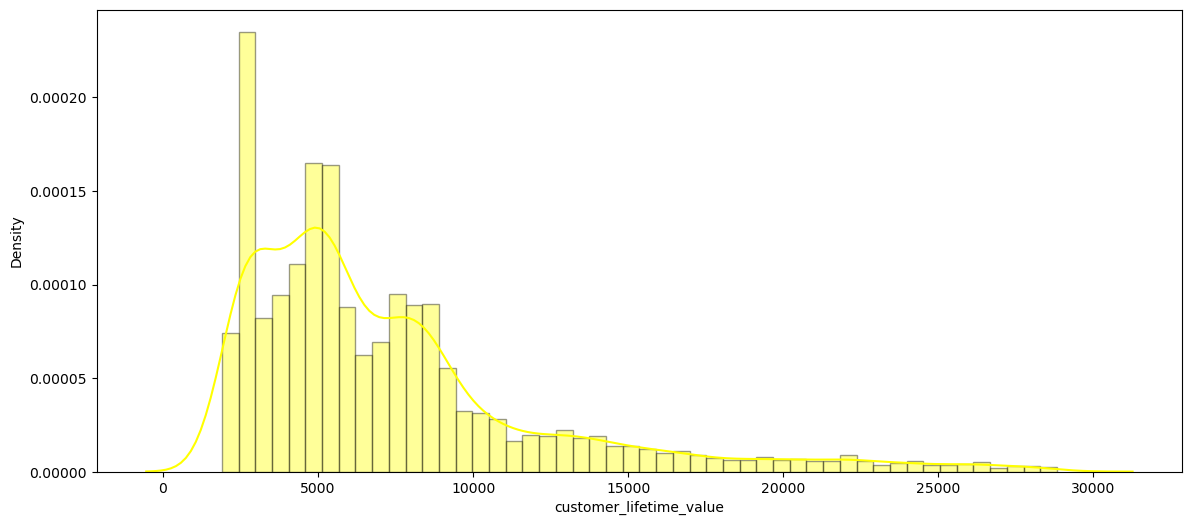

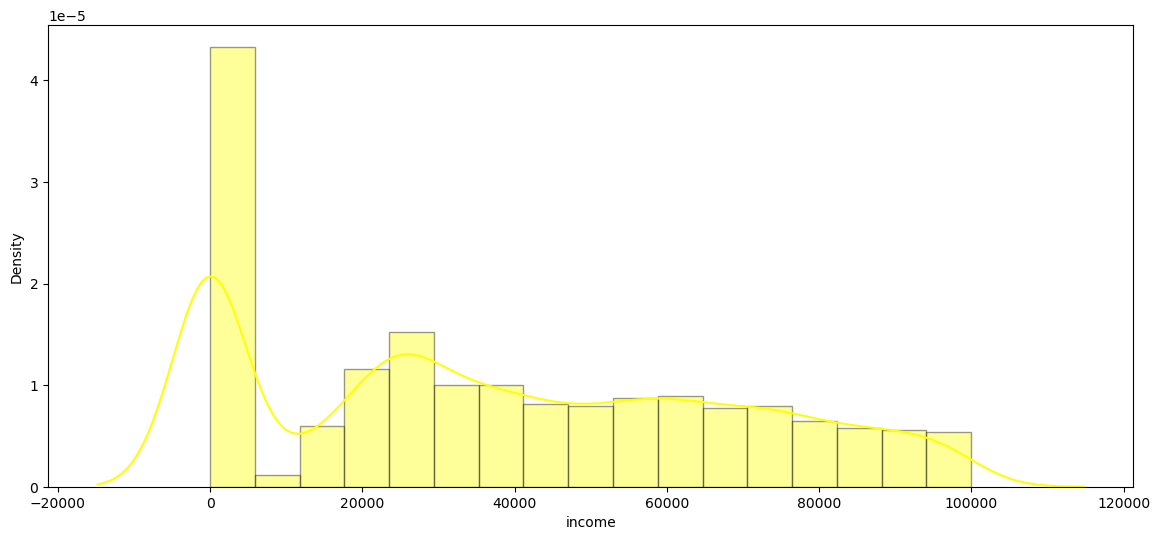

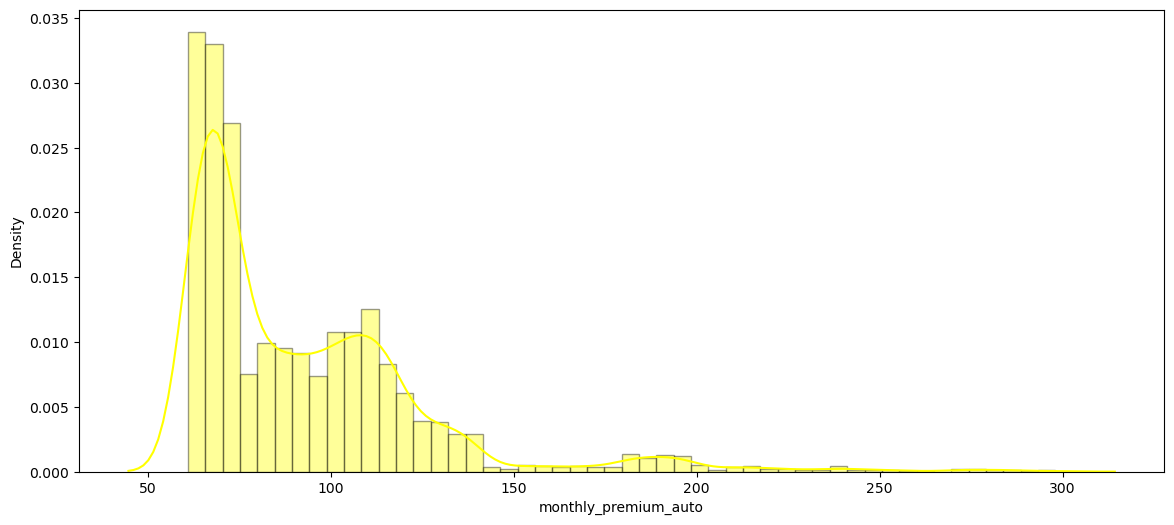

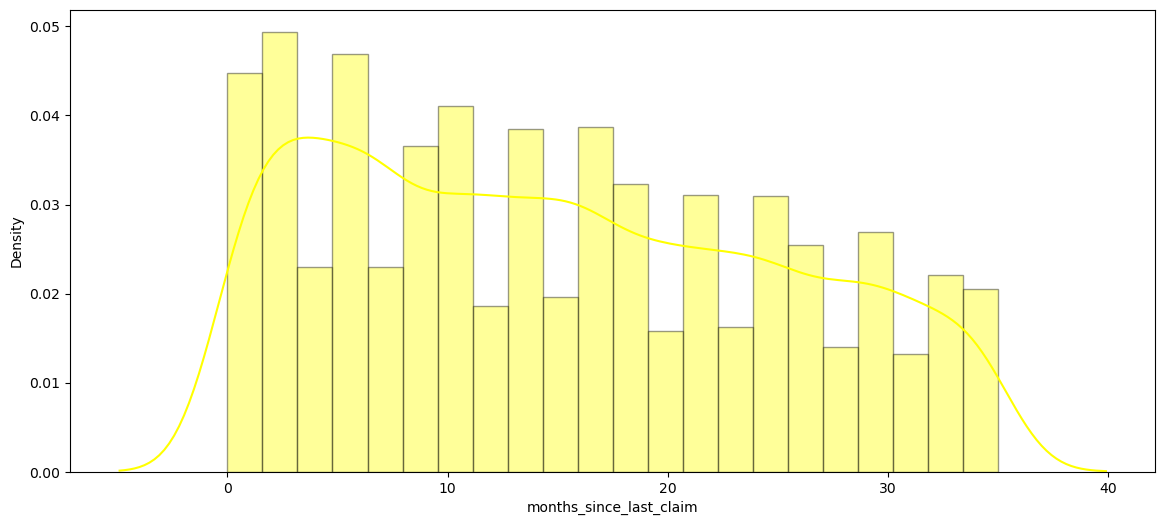

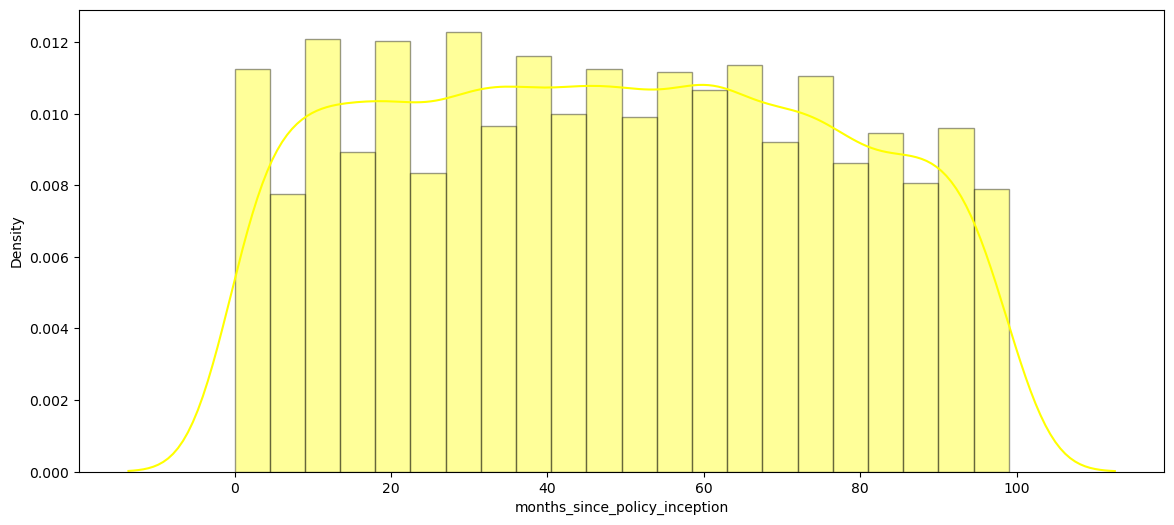

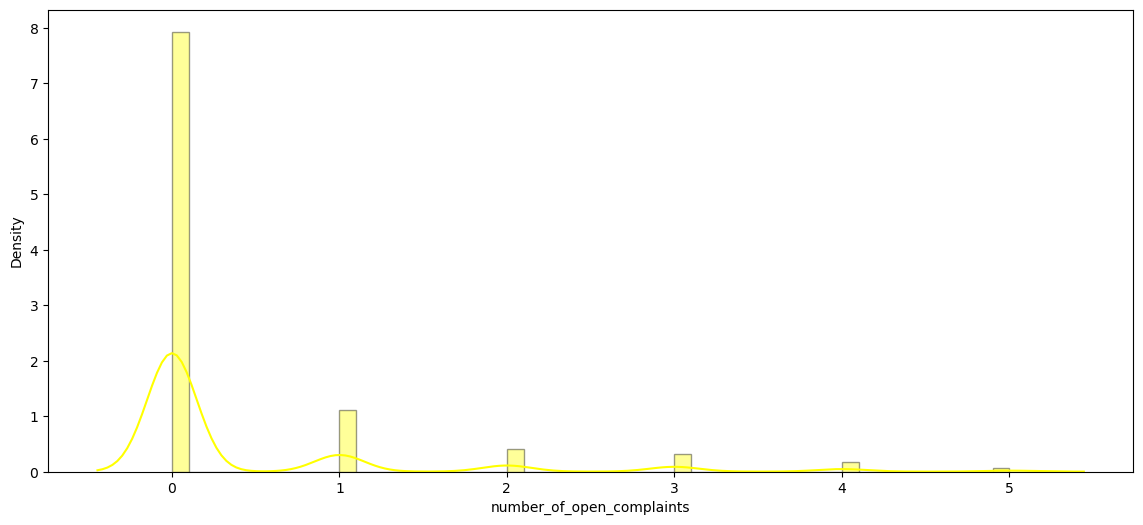

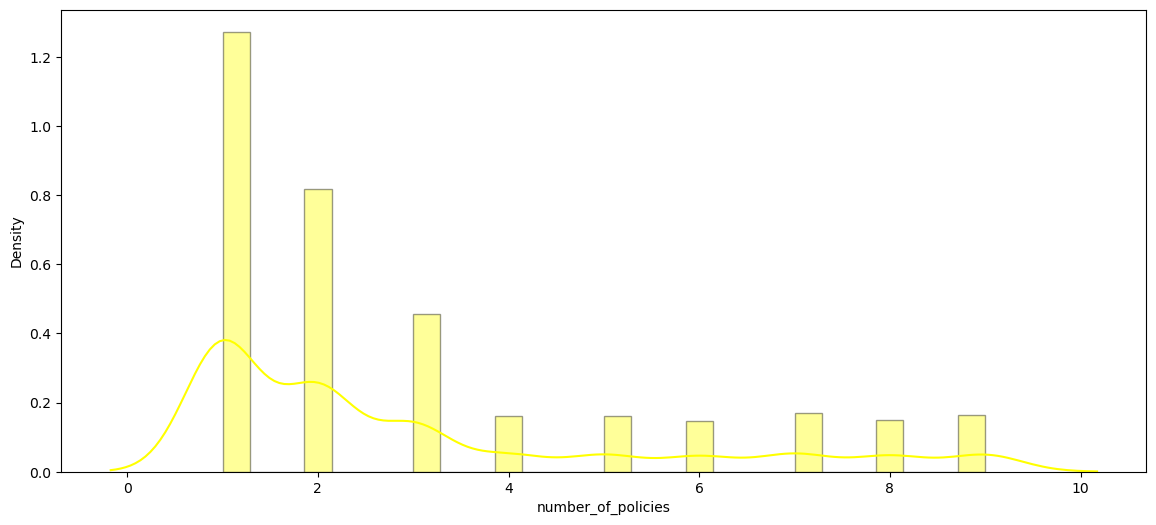

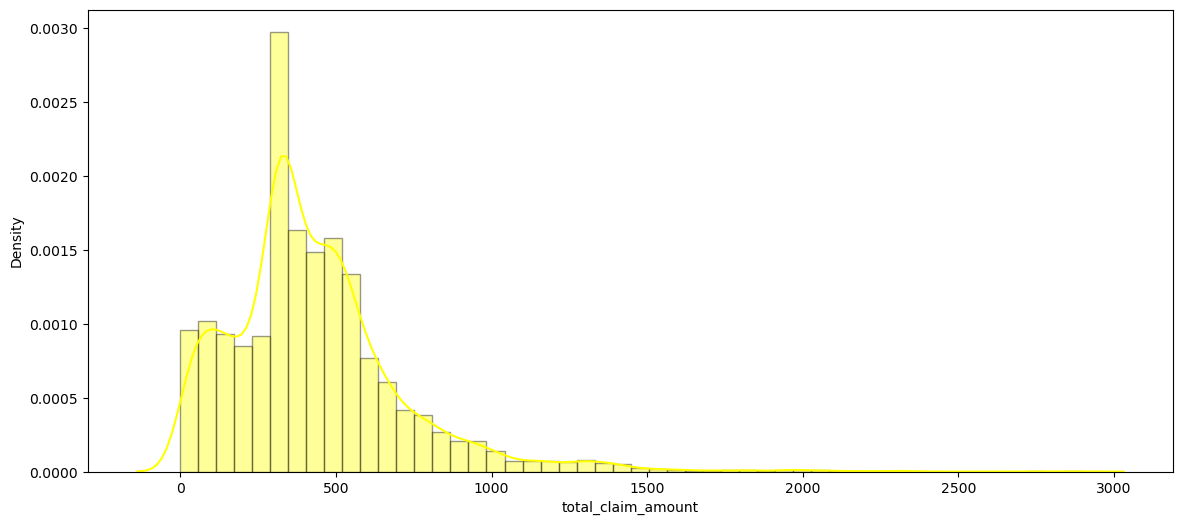

In [15]:
for column in nums:
    plt.figure(figsize = (14,6))
    sns.distplot(nums[column], color='yellow', hist_kws={'edgecolor': 'black'})
plt.show()

First, I try with the MinMaxScaler.

In [16]:
transformer = MinMaxScaler().fit(nums)
transformed_nums = transformer.transform(nums)
minmax_cols = nums.columns.tolist()
minmax_nums = pd.DataFrame(transformed_nums, columns=minmax_cols)

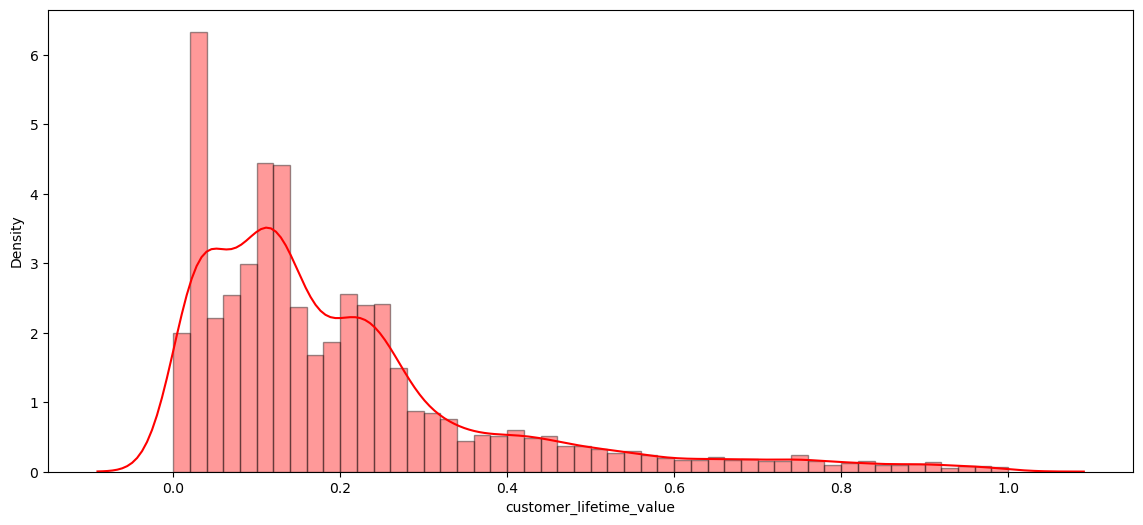

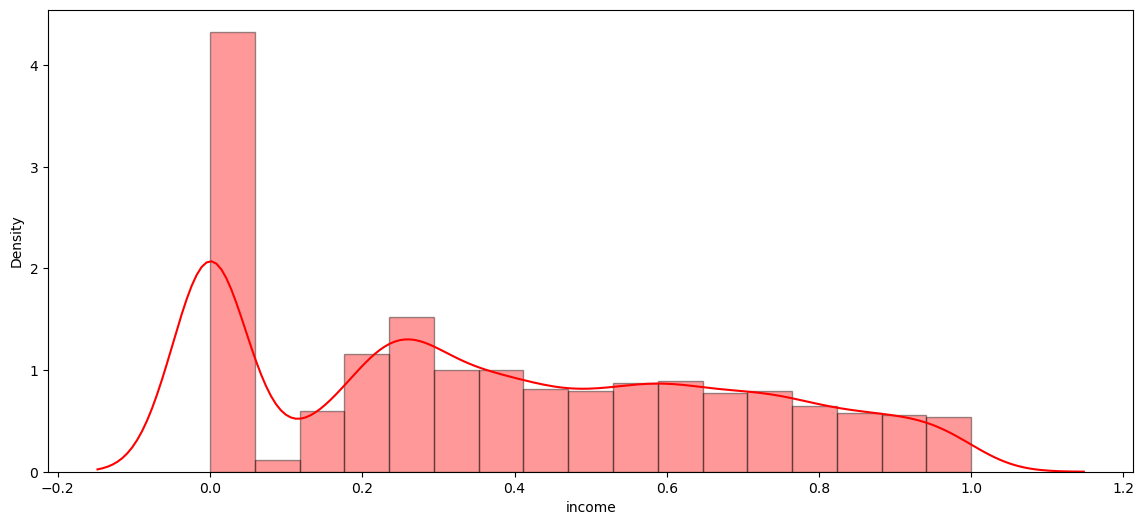

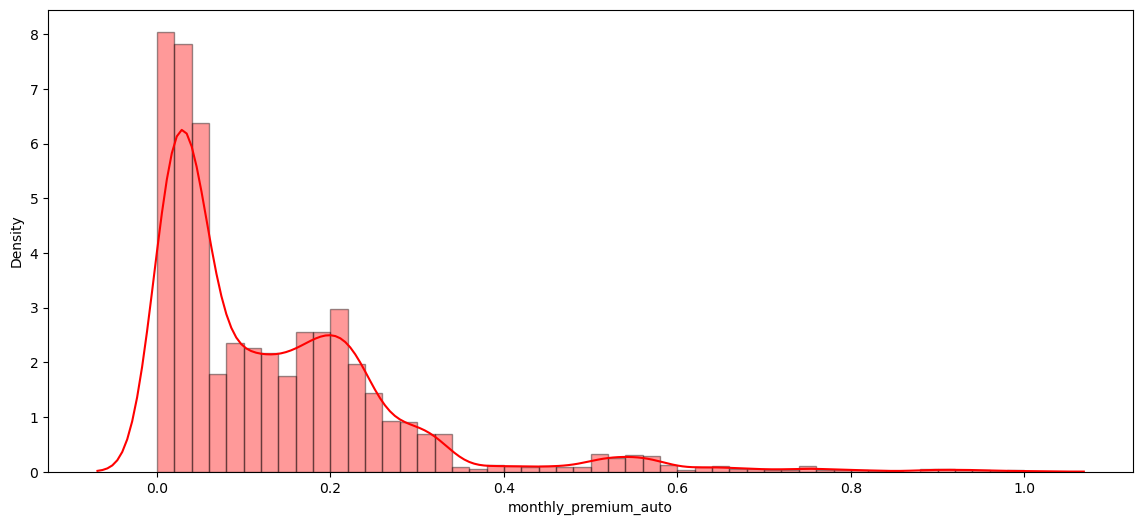

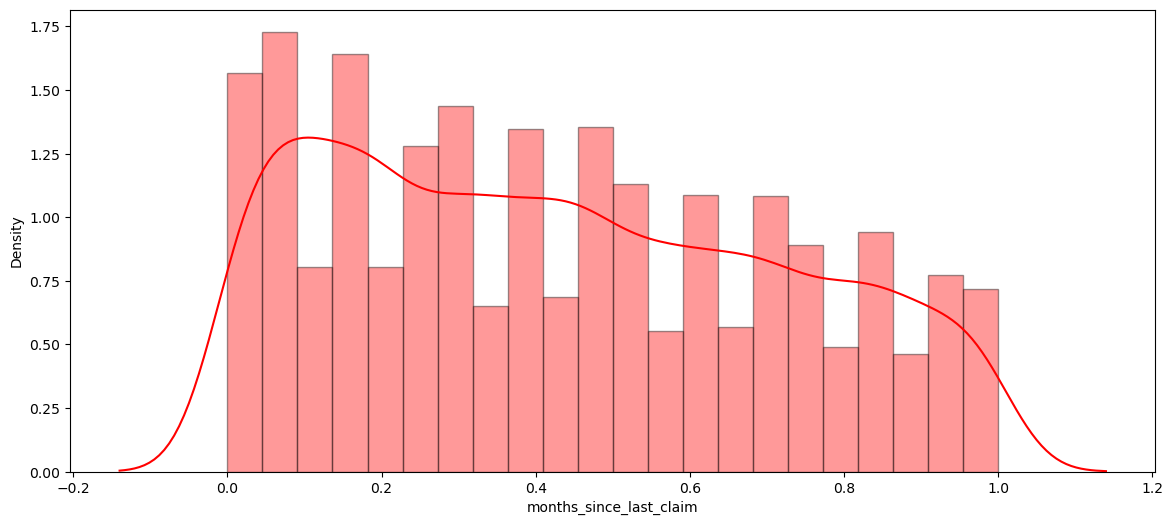

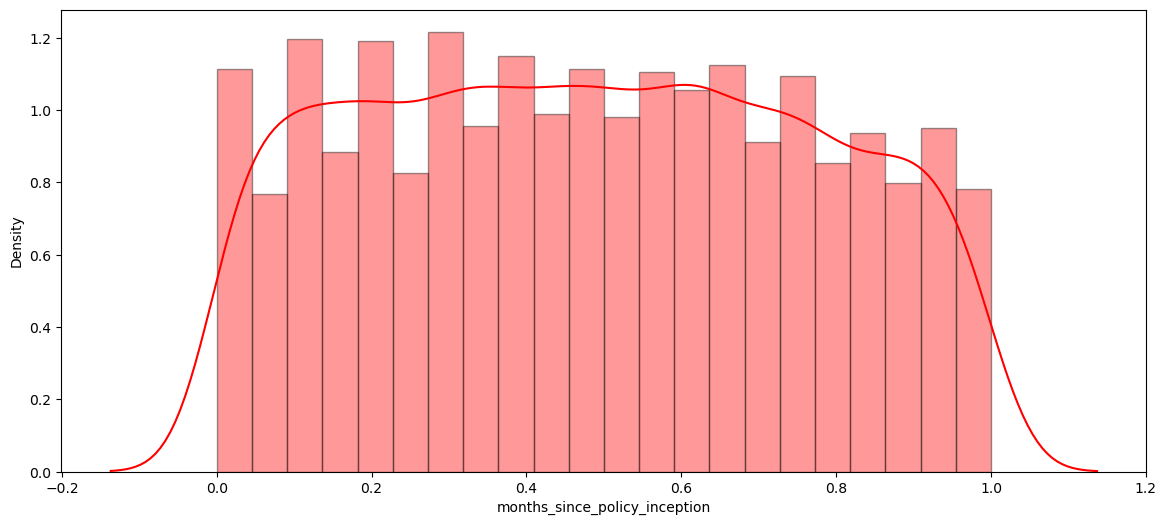

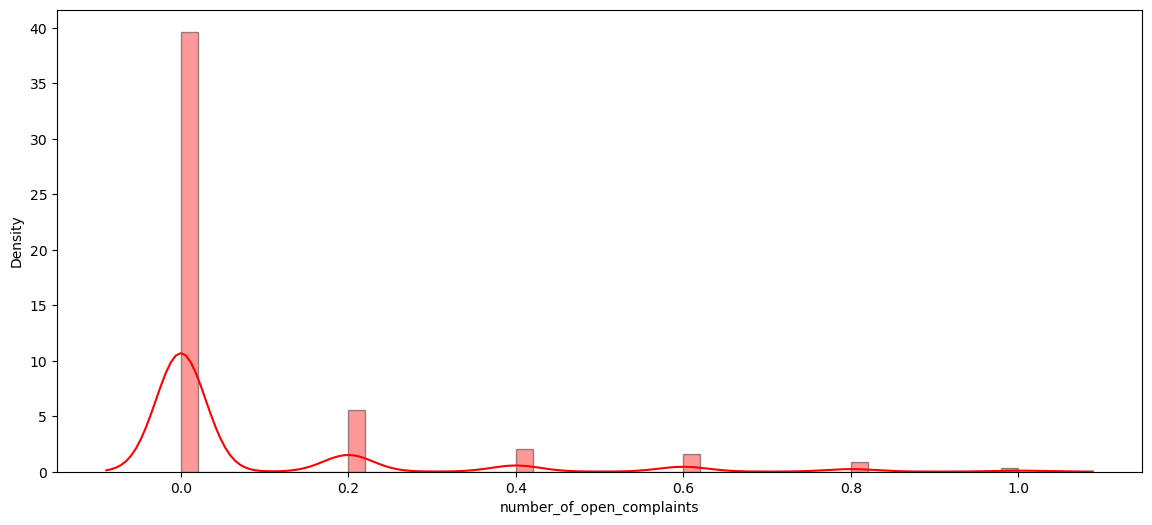

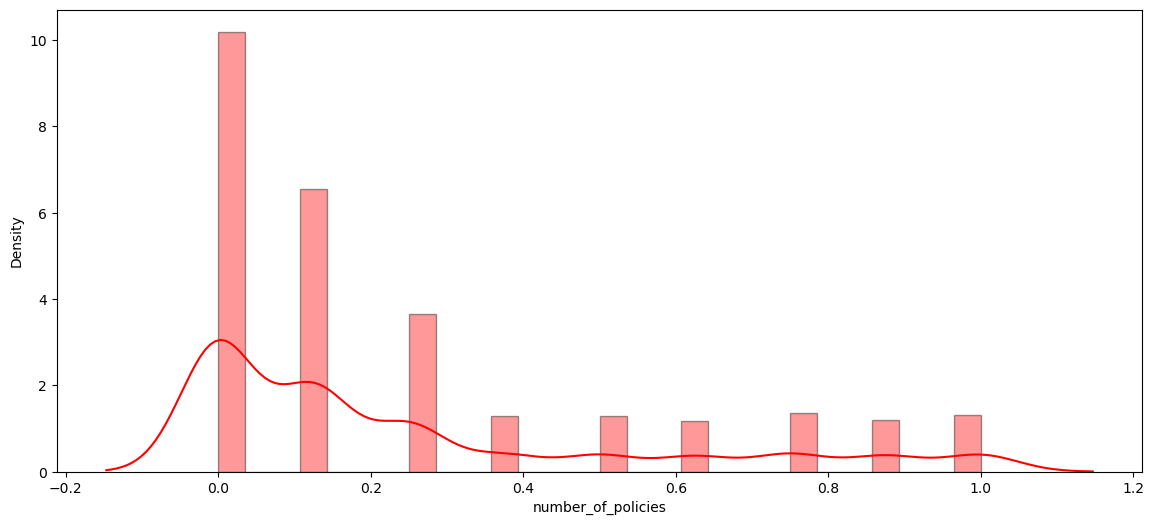

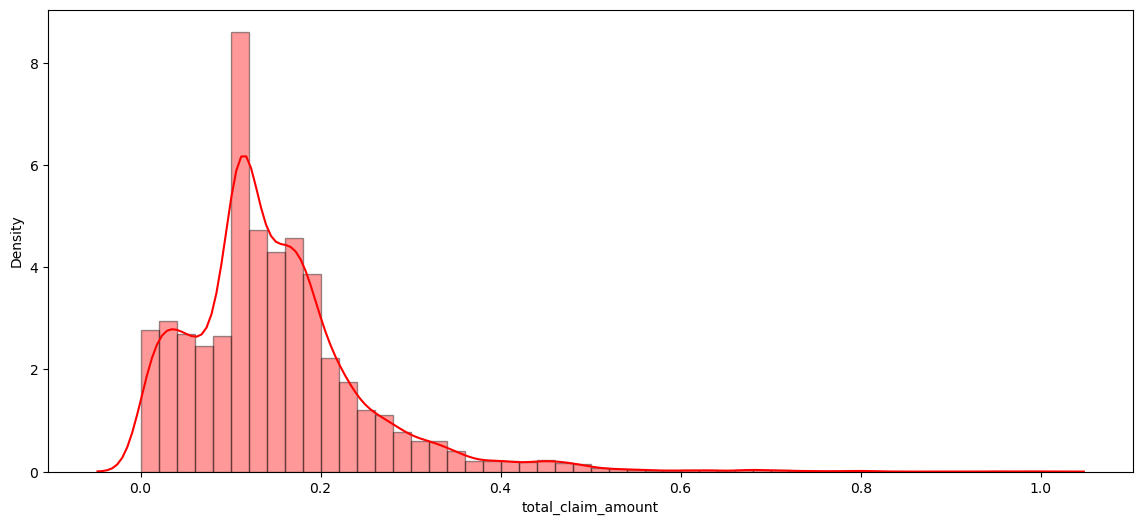

In [17]:
for column in minmax_nums:
    plt.figure(figsize = (14,6))
    sns.distplot(minmax_nums[column], color='red', hist_kws={'edgecolor': 'black'})
plt.show()

Now I try with the StandardScaler.

In [18]:
transformer = StandardScaler().fit(nums)
transformed_nums = transformer.transform(nums)
standardized_cols = nums.columns.tolist()
standardized_nums = pd.DataFrame(transformed_nums, columns=standardized_cols)

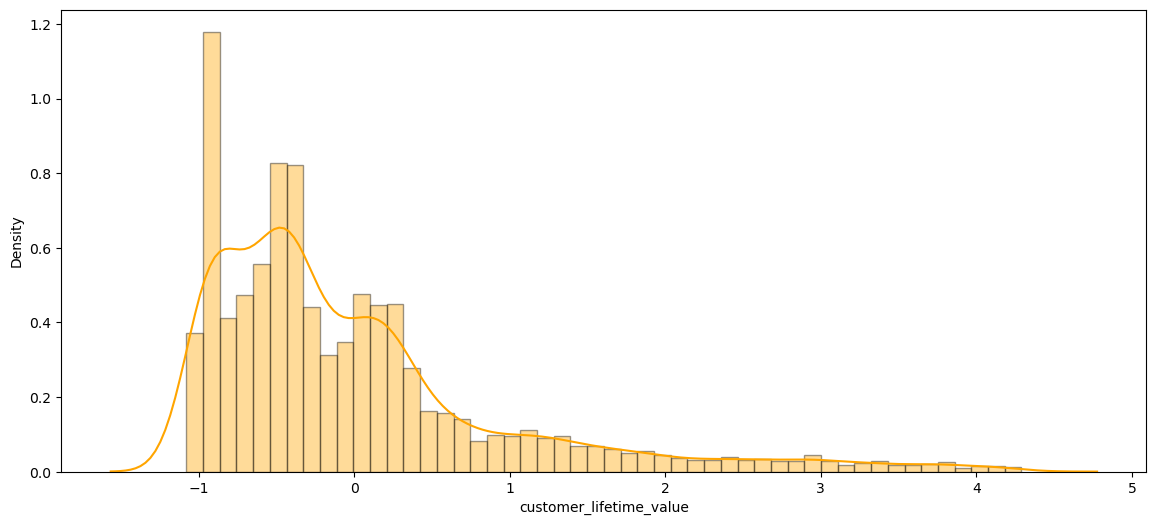

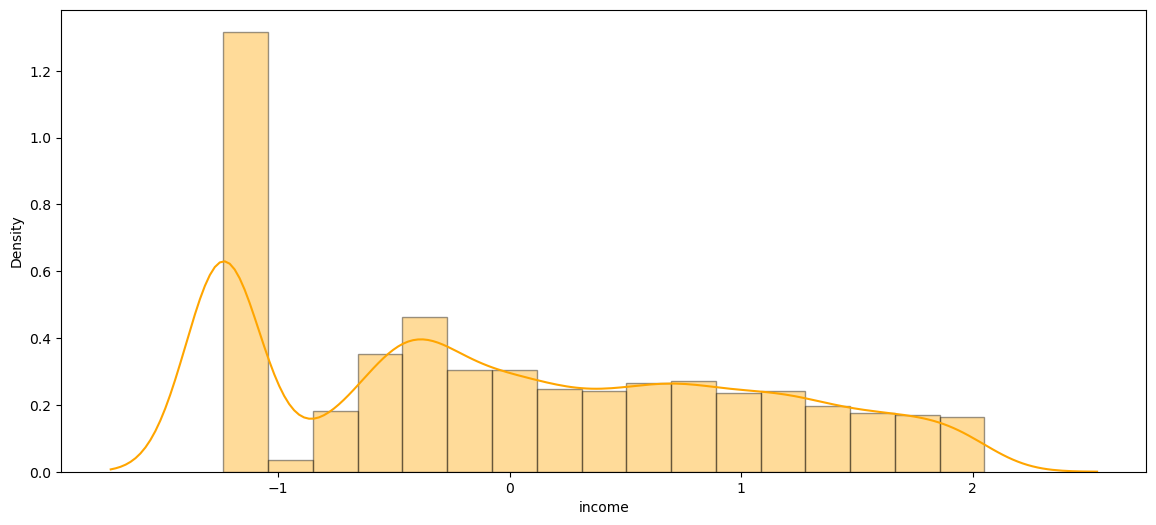

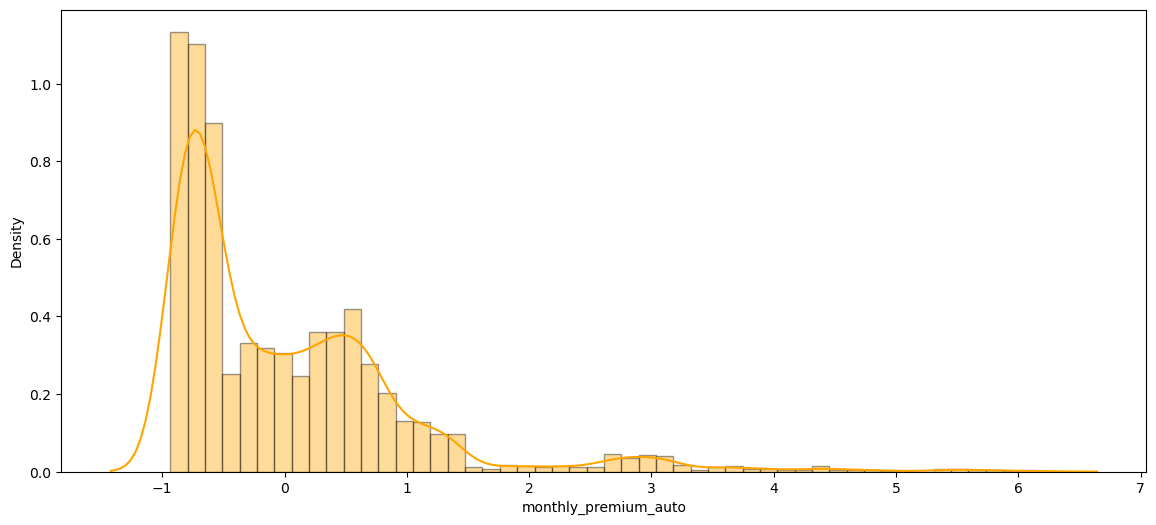

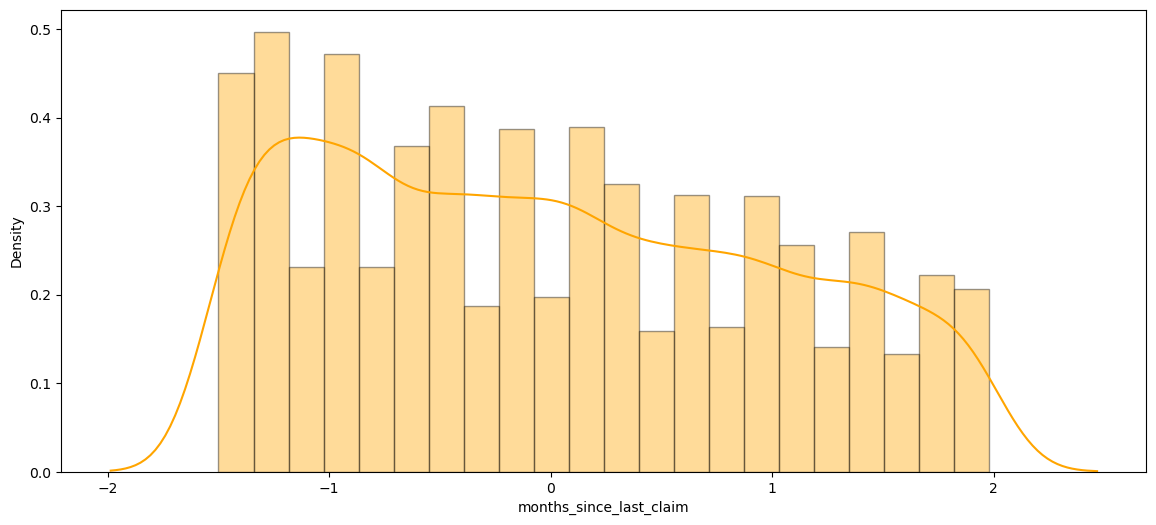

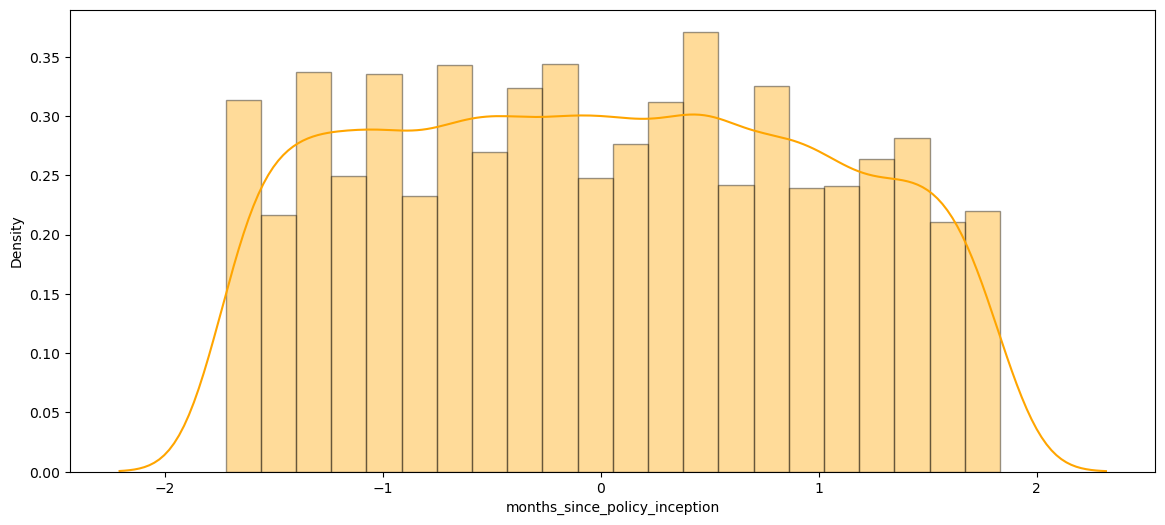

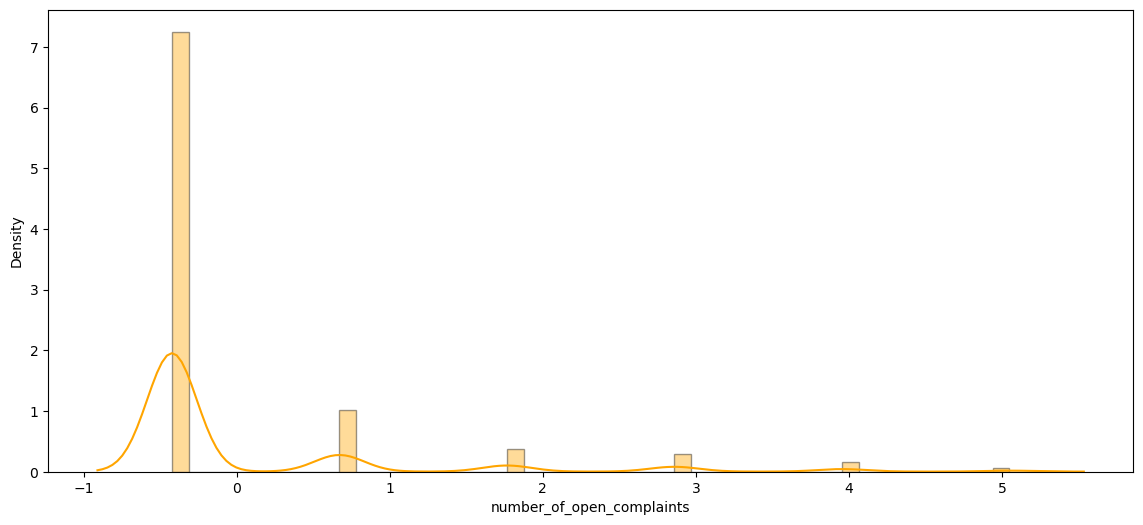

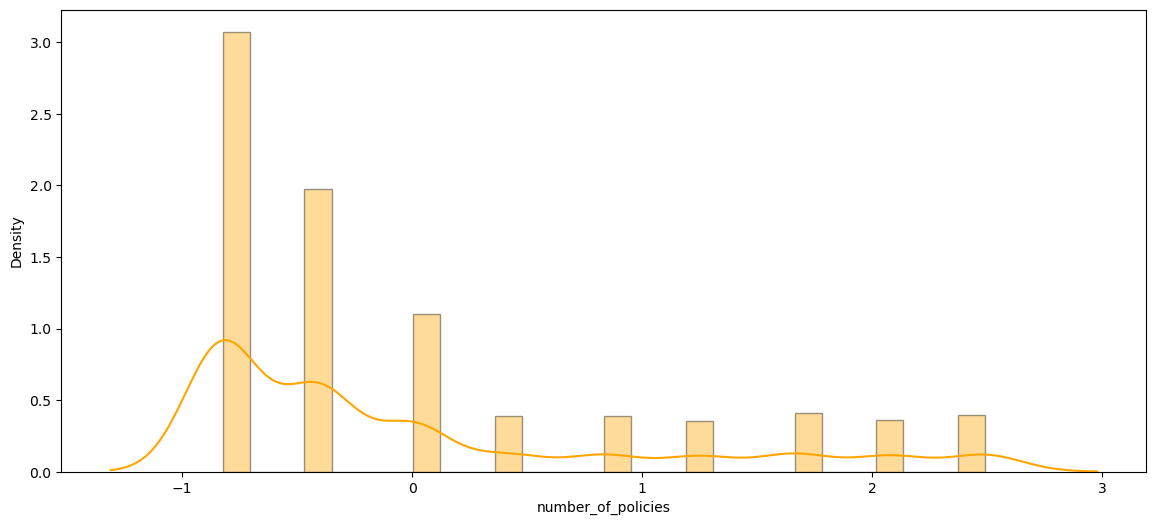

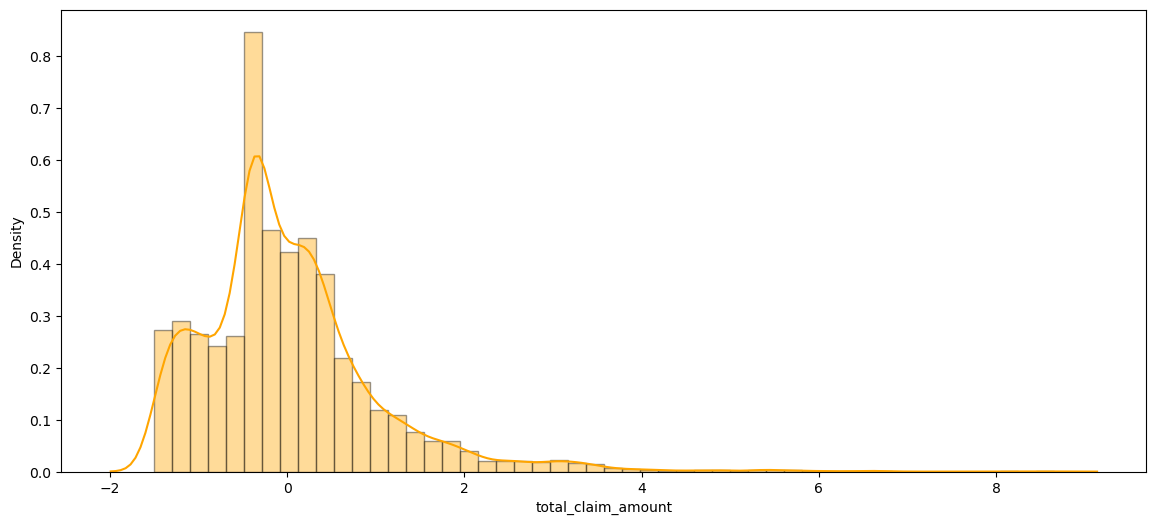

In [19]:
for column in standardized_nums:
    plt.figure(figsize = (14,6))
    sns.distplot(standardized_nums[column], color='orange', hist_kws={'edgecolor': 'black'})
plt.show()

I'll try with the Normalizer to compare between all three methods.

In [20]:
nums = nums.dropna(subset=['customer_lifetime_value'])

In [21]:
transformer = Normalizer().fit(nums)
transformed_nums = transformer.transform(nums)
normalized_cols = nums.columns.tolist()
normalized_nums = pd.DataFrame(transformed_nums, columns=normalized_cols)

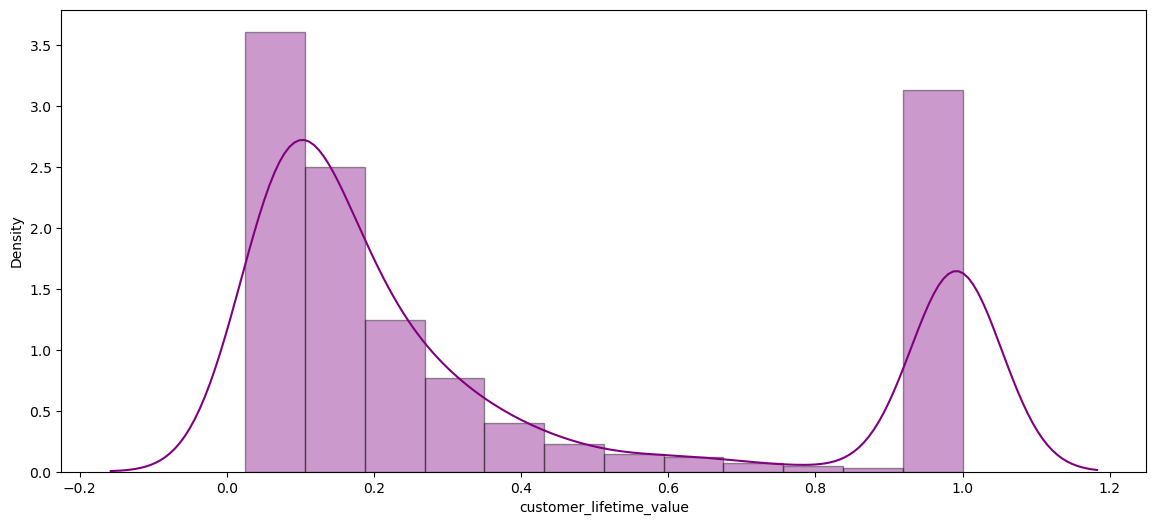

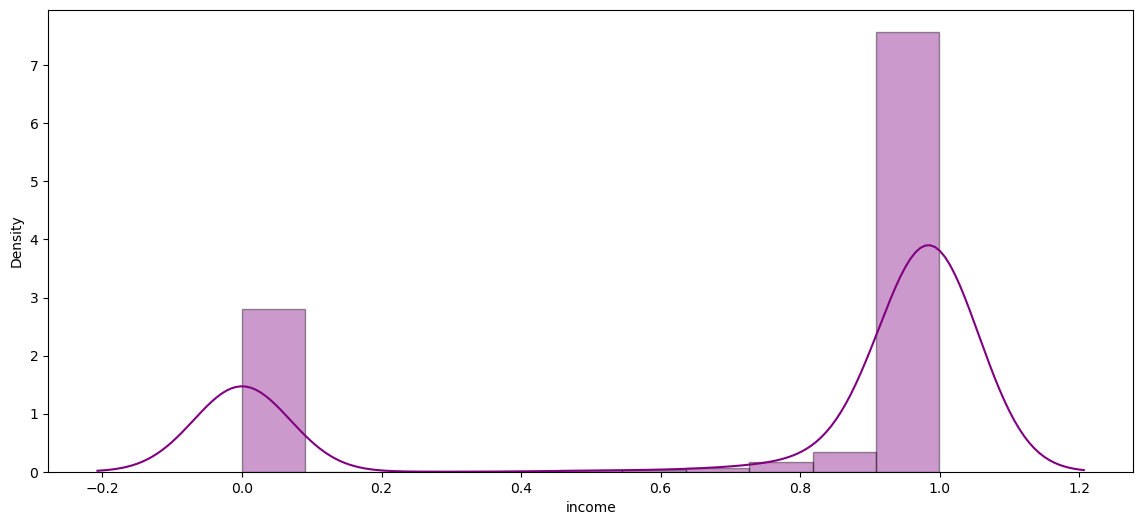

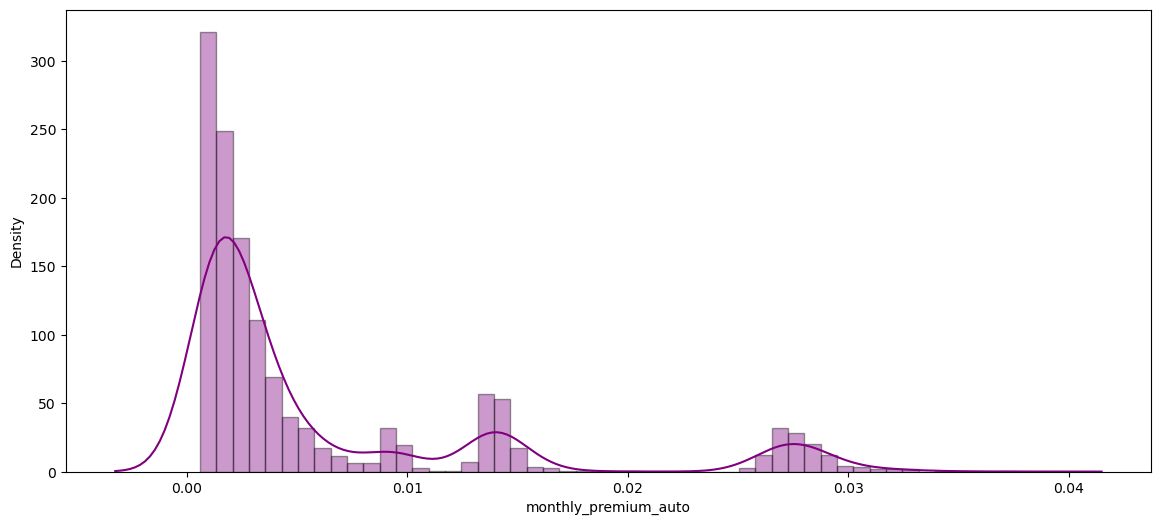

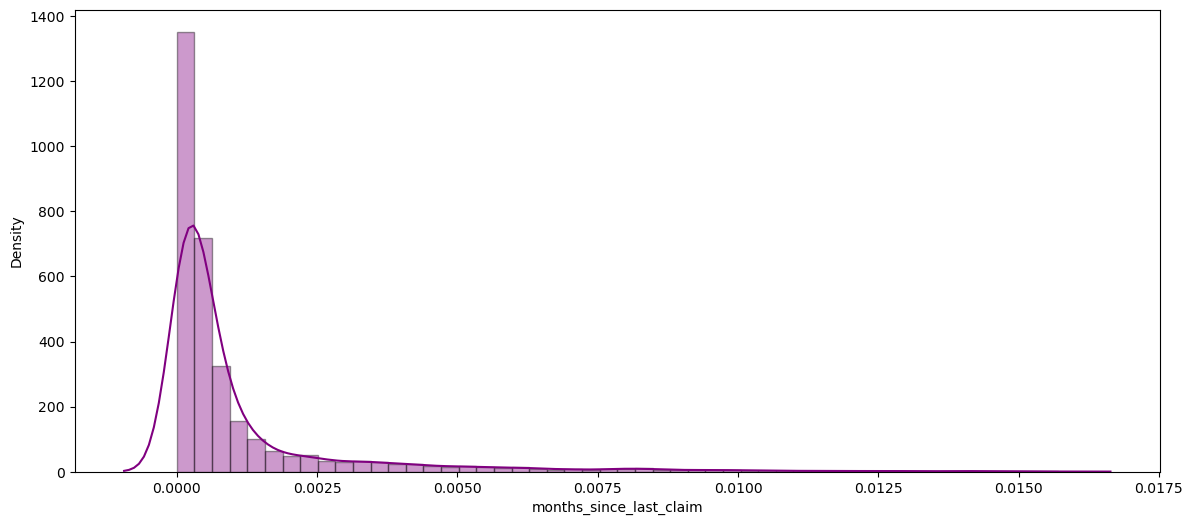

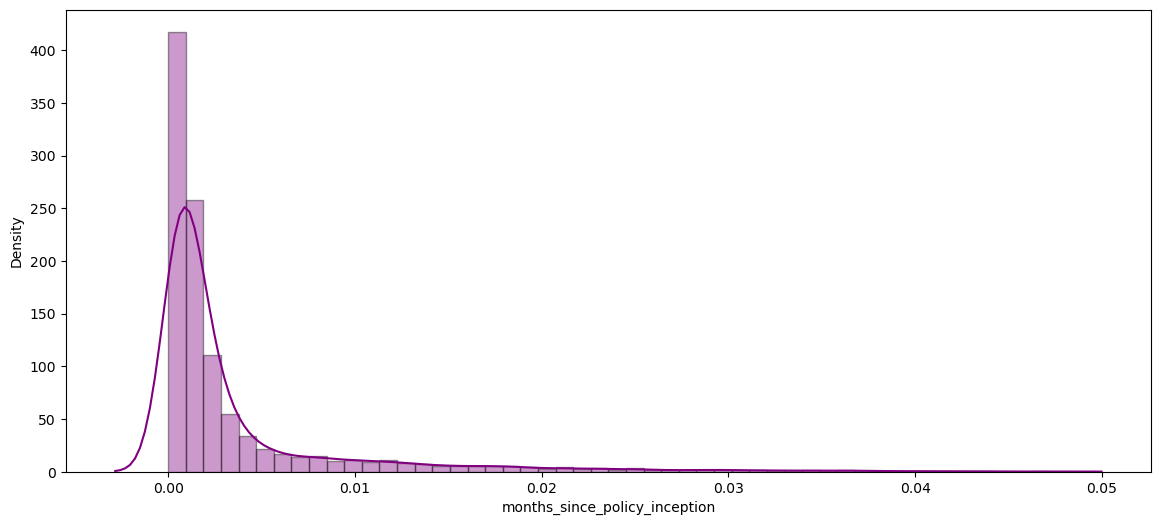

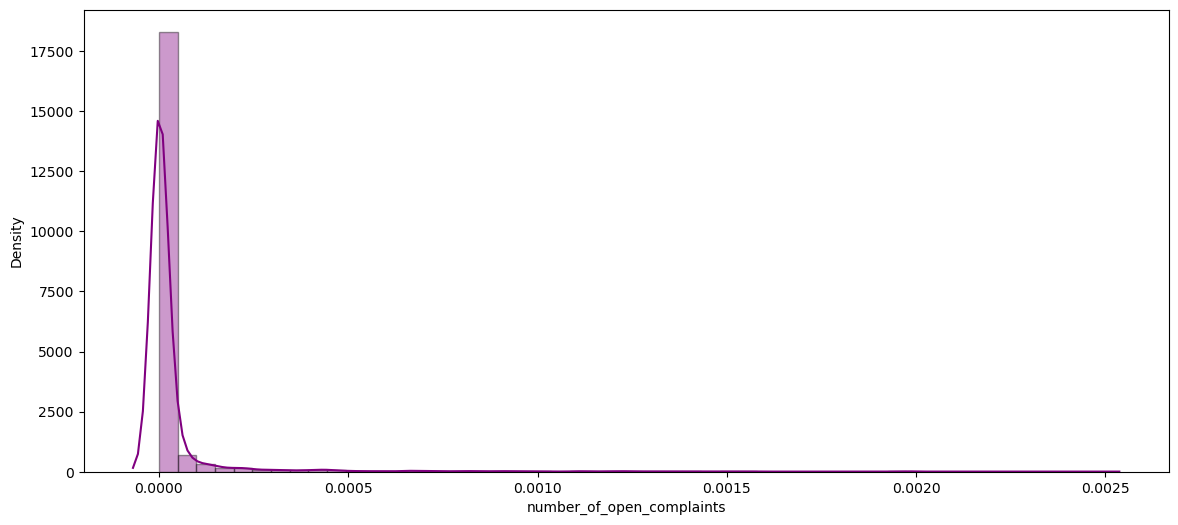

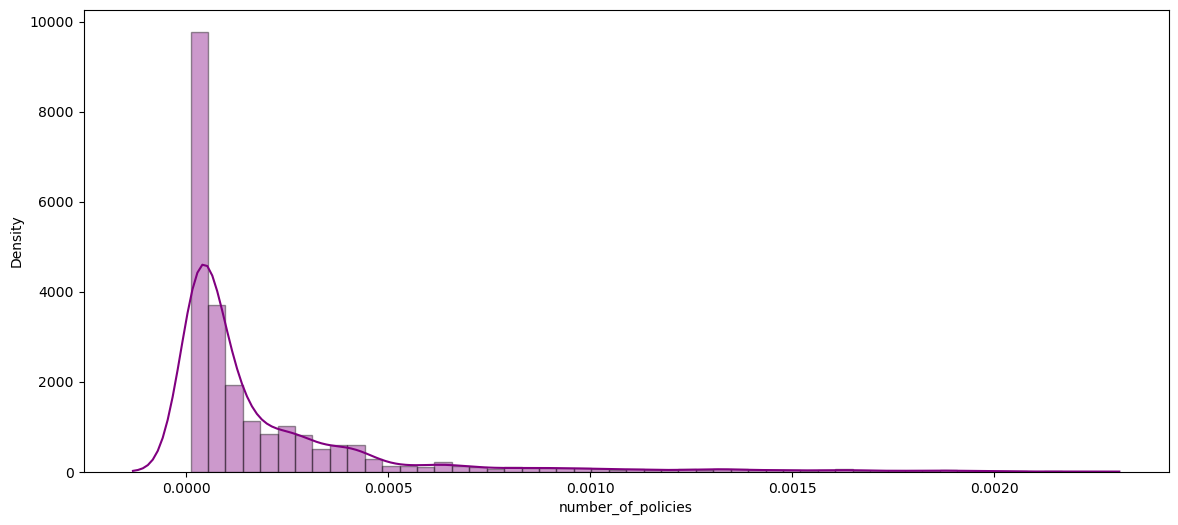

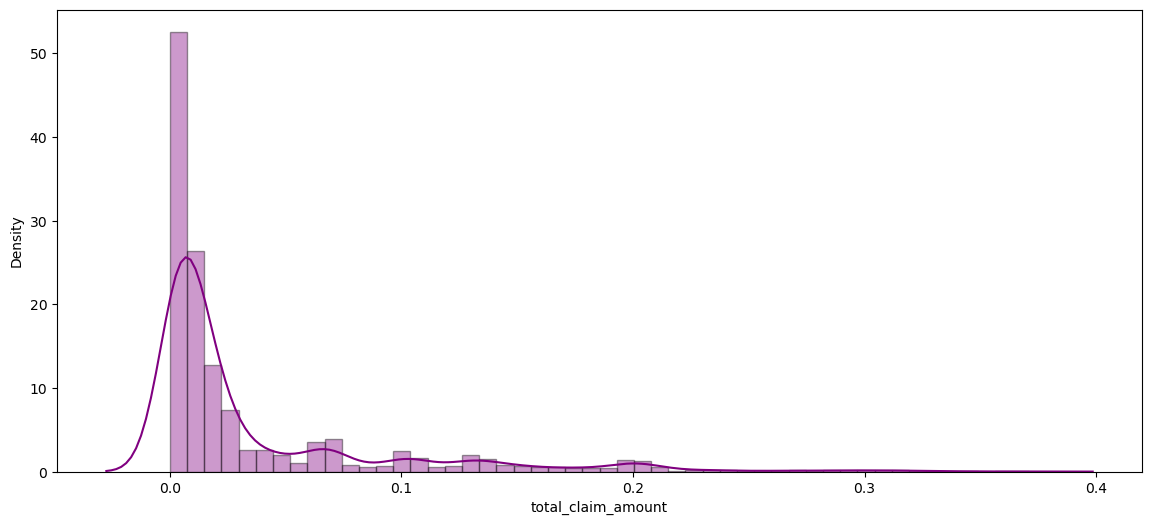

In [22]:
for column in normalized_nums:
    plt.figure(figsize = (14,6))
    sns.distplot(normalized_nums[column], color='purple', hist_kws={'edgecolor': 'black'})
plt.show()

The normalizer changes the values too much, moving them too extremes. I prefer the StandardScaler sinc ethe data looks less skewed but not moved to its extremes.

In [23]:
standardized_nums

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount
0,-0.907433,0.613565,-0.695161,1.681574,-1.540709,-0.422600,-0.824095,-0.154995
1,-0.066635,-1.236662,0.052991,-0.207328,-0.213475,-0.422600,2.076972,2.467233
2,1.111574,0.366743,0.471956,0.289751,-0.356960,-0.422600,-0.409657,0.482994
3,0.066250,-1.236662,0.412103,0.289751,0.611562,-0.422600,1.662534,0.354488
4,-0.897427,0.204617,-0.575457,-0.306744,-0.141733,-0.422600,-0.824095,-1.021330
...,...,...,...,...,...,...,...,...
8923,3.209285,1.128679,-0.575457,0.289751,1.472470,-0.422600,-0.409657,-0.810246
8924,-0.841025,-0.526347,-0.395900,-0.107912,-0.715672,-0.422600,-0.824095,-0.174701
8925,0.169560,-1.236662,-0.216344,-0.604992,-0.392831,2.859194,-0.409657,1.270774
8926,0.042036,-0.515266,0.112843,1.880406,-1.612452,-0.422600,0.004781,0.921034


### 4. Encode the categorical variables

In [24]:
cats = customer_data.select_dtypes(include=[np.object])
cats.columns

Index(['customer', 'state', 'response', 'coverage', 'education',
       'employment_status', 'location_code', 'policy', 'renew_offer_type',
       'sales_channel', 'vehicle_class', 'effective_to_date'],
      dtype='object')

As assigned I one hot encode those columns that don't have categories with an inherent order.

In [25]:
cats_onehot = cats[['state', 'policy', 'renew_offer_type', 'sales_channel', 'vehicle_class']].copy()

In [26]:
cats_onehot = pd.get_dummies(cats_onehot, drop_first=True)
cats_onehot

,state_California,state_Nevada,state_Oregon,state_Washington,policy_Personal,policy_Special,renew_offer_type_Offer 3-4,sales_channel_Indirect,vehicle_class_Medium-Class Car,vehicle_class_Normal Car
0,0,0,0,1,0,0,0,0,0,1
1,0,0,0,0,1,0,1,0,0,1
2,0,1,0,0,1,0,0,0,0,1
3,1,0,0,0,0,0,0,1,1,0
4,0,0,0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
9129,1,0,0,0,1,0,0,1,0,1
9130,1,0,0,0,0,0,0,0,0,1
9131,1,0,0,0,0,0,0,0,0,1
9132,1,0,0,0,1,0,1,0,0,1


Those with an inherent order I encode ordinally.

In [27]:
cats.coverage.unique()

array(['Basic', 'Extended', 'Premium'], dtype=object)

In [28]:
cats['coverage'] = cats['coverage'].map({'Basic' : 0, 'Extended' : 1, 'Premium' : 2})

In [29]:
cats.education.unique()

array(['Bachelor or College', 'Doctor or Master', 'High School or Below'],
      dtype=object)

In [30]:
cats['education'] = cats['education'].map({'High School or Below' : 0, 'Bachelor or College' : 1, 'Doctor or Master' : 2})

In [31]:
cats.employment_status.unique()

array(['Employed', 'Unemployed', 'Other status'], dtype=object)

In [32]:
cats['employment_status'] = cats['employment_status'].map({'Other status' : 0, 'Unemployed' : 1, 'Employed' : 2})

In [33]:
cats.location_code.unique()

array(['Suburban', 'Rural', 'Urban'], dtype=object)

In [34]:
cats['location_code'] = cats['location_code'].map({'Rural' : 0, 'Suburban' : 1, 'Urban' : 2})

Last but not least, I encode the variable response to have numeric values.

In [35]:
cats['response'] = (cats['response'] == 'Yes').astype(int)

In [36]:
cats_ordinal = cats[['response', 'location_code', 'employment_status', 'education', 'coverage']].copy()

### 5. The time variable can be useful. Try to transform its data into a useful one. 
*Hint: Day week and month as integers might be useful.*

In [37]:
cats['effective_to_date'] = pd.to_datetime(cats['effective_to_date'])

As hinted I separate the day, month and year in three individual columns and convert the values to integers.  Afterwards, I can use the day, month, and year columns as new features in a machine learning model. For example, I can create a new feature that represents the number of days since a certain date or the number of days until a certain date.

In [38]:
cats['effective_to_date_day'] = cats['effective_to_date'].dt.day
cats['effective_to_date_month'] = cats['effective_to_date'].dt.month
cats['effective_to_date_year'] = cats['effective_to_date'].dt.year

In [39]:
cats_ints = cats[['effective_to_date_day', 'effective_to_date_month', 'effective_to_date_year']].copy()

In [40]:
cats_encoded = pd.concat([cats_ordinal, cats_onehot, cats_ints], axis=1)
cats_encoded.columns

Index(['response', 'location_code', 'employment_status', 'education',
       'coverage', 'state_California', 'state_Nevada', 'state_Oregon',
       'state_Washington', 'policy_Personal', 'policy_Special',
       'renew_offer_type_Offer 3-4', 'sales_channel_Indirect',
       'vehicle_class_Medium-Class Car', 'vehicle_class_Normal Car',
       'effective_to_date_day', 'effective_to_date_month',
       'effective_to_date_year'],
      dtype='object')

### 6. Since the model will only accept numerical data, check and make sure that every column is numerical, if some are not, change it using encoding.

In [41]:
customer_data_cleaned = pd.concat([cats_encoded, nums], axis=1)
customer_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8928 entries, 0 to 9133
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   response                        8928 non-null   int64  
 1   location_code                   8928 non-null   int64  
 2   employment_status               8928 non-null   int64  
 3   education                       8928 non-null   int64  
 4   coverage                        8928 non-null   int64  
 5   state_California                8928 non-null   uint8  
 6   state_Nevada                    8928 non-null   uint8  
 7   state_Oregon                    8928 non-null   uint8  
 8   state_Washington                8928 non-null   uint8  
 9   policy_Personal                 8928 non-null   uint8  
 10  policy_Special                  8928 non-null   uint8  
 11  renew_offer_type_Offer 3-4      8928 non-null   uint8  
 12  sales_channel_Indirect          89

All columns are numerical.

In [42]:
customer_data_cleaned.to_csv("customer_data_cleaned.csv", index=False)

In [43]:
# I can also combine the encoded categorical vars with the standardized or otherwise transformed numericals.
customer_data_cleaned_standardized = pd.concat([cats_encoded, standardized_nums], axis=1)
# I'll most likely encounter some NaNs again since the standardization modified some values.
customer_data_cleaned_standardized.isna().sum()

response                          199
location_code                     199
employment_status                 199
education                         199
coverage                          199
state_California                  199
state_Nevada                      199
state_Oregon                      199
state_Washington                  199
policy_Personal                   199
policy_Special                    199
renew_offer_type_Offer 3-4        199
sales_channel_Indirect            199
vehicle_class_Medium-Class Car    199
vehicle_class_Normal Car          199
effective_to_date_day             199
effective_to_date_month           199
effective_to_date_year            199
customer_lifetime_value           199
income                            199
monthly_premium_auto              199
months_since_last_claim           199
months_since_policy_inception     199
number_of_open_complaints         199
number_of_policies                199
total_claim_amount                199
dtype: int64

In [44]:
customer_data_cleaned_standardized = customer_data_cleaned.dropna()
customer_data_cleaned_standardized.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8928 entries, 0 to 9133
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   response                        8928 non-null   int64  
 1   location_code                   8928 non-null   int64  
 2   employment_status               8928 non-null   int64  
 3   education                       8928 non-null   int64  
 4   coverage                        8928 non-null   int64  
 5   state_California                8928 non-null   uint8  
 6   state_Nevada                    8928 non-null   uint8  
 7   state_Oregon                    8928 non-null   uint8  
 8   state_Washington                8928 non-null   uint8  
 9   policy_Personal                 8928 non-null   uint8  
 10  policy_Special                  8928 non-null   uint8  
 11  renew_offer_type_Offer 3-4      8928 non-null   uint8  
 12  sales_channel_Indirect          89

Also in the standardized version all columns are numerical.

In [45]:
customer_data_cleaned_standardized.to_csv("customer_data_cleaned_standardized.csv", index=False)